# Semiconductor Defect Detection - Operator Dashboard

**Purpose:** Help engineers and operators understand how the ML model detects defects

**Key Takeaways at a Glance:**
- The model catches ~30% of defects before downstream inspection
- When the model flags a unit, there's a 40% chance it's actually defective
- **Key sensors to watch:** 103, 33, 59, 31, 205

---

In [1]:
# Setup - Run this cell first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Style settings for clear visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Dashboard ready!")

Dashboard ready!


In [2]:
# Load and prepare data
df = pd.read_csv('uci-secom.csv')

# Separate features and target
X = df.drop('Pass/Fail', axis=1)
y = (df['Pass/Fail'] == -1).astype(int)  # 1 = Defect, 0 = Pass

# Train-test split (same as main analysis)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total units: {len(df):,}")
print(f"Defect rate: {y.mean()*100:.1f}%")
print(f"Training set: {len(X_train):,} units ({y_train.sum()} defects)")
print(f"Test set: {len(X_test):,} units ({y_test.sum()} defects)")

Total units: 1,567
Defect rate: 93.4%
Training set: 1,253 units (1170 defects)
Test set: 314 units (293 defects)


---
## 1. Model Performance Summary

**What does the model do?** It looks at sensor readings and predicts whether a unit might be defective.

**How well does it work?**

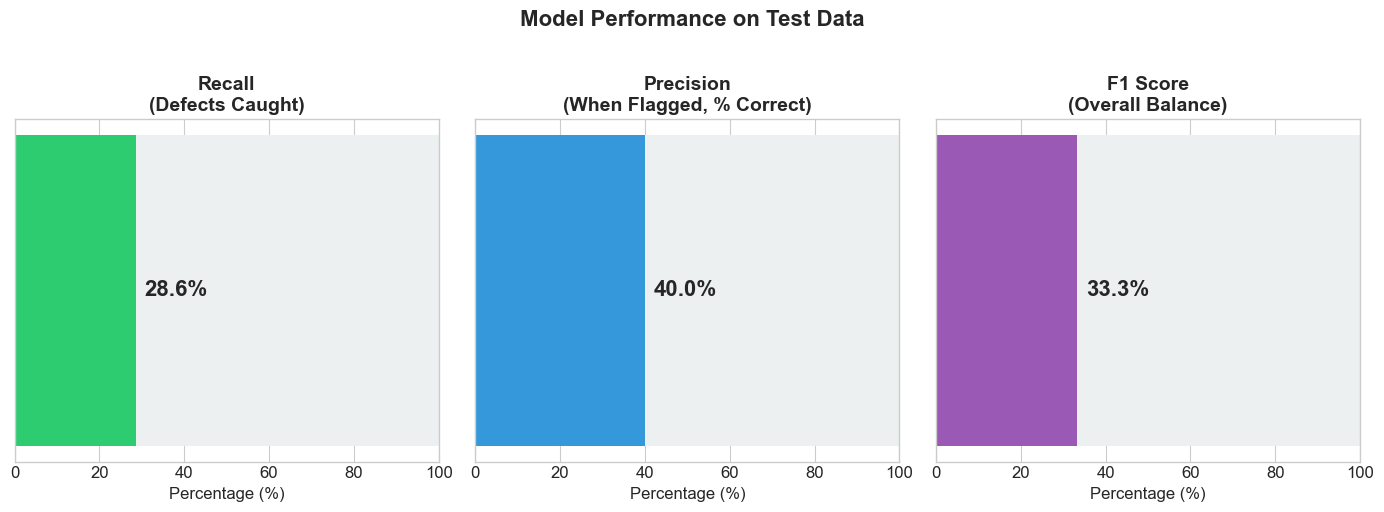


WHAT THIS MEANS FOR OPERATIONS:

1. Out of every 100 actual defects, the model catches ~29
2. Out of every 10 units the model flags, ~4 are real defects
3. The model is a SCREENING tool - it helps prioritize inspection



In [3]:
# Performance metrics visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Metric values from the analysis
metrics = {
    'Recall\n(Defects Caught)': 28.6,
    'Precision\n(When Flagged, % Correct)': 40.0,
    'F1 Score\n(Overall Balance)': 33.3
}

colors = ['#2ecc71', '#3498db', '#9b59b6']

for idx, (metric, value) in enumerate(metrics.items()):
    ax = axes[idx]
    
    # Create a gauge-like visualization
    ax.barh([0], [100], color='#ecf0f1', height=0.5)
    ax.barh([0], [value], color=colors[idx], height=0.5)
    
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_xlabel('Percentage (%)')
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.text(value + 2, 0, f'{value}%', va='center', fontsize=16, fontweight='bold')

plt.suptitle('Model Performance on Test Data', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("WHAT THIS MEANS FOR OPERATIONS:")
print("="*60)
print("\n1. Out of every 100 actual defects, the model catches ~29")
print("2. Out of every 10 units the model flags, ~4 are real defects")
print("3. The model is a SCREENING tool - it helps prioritize inspection")
print("\n" + "="*60)

---
## 2. Confusion Matrix: What Happens to Each Unit?

This shows exactly what the model does with the 314 test units:

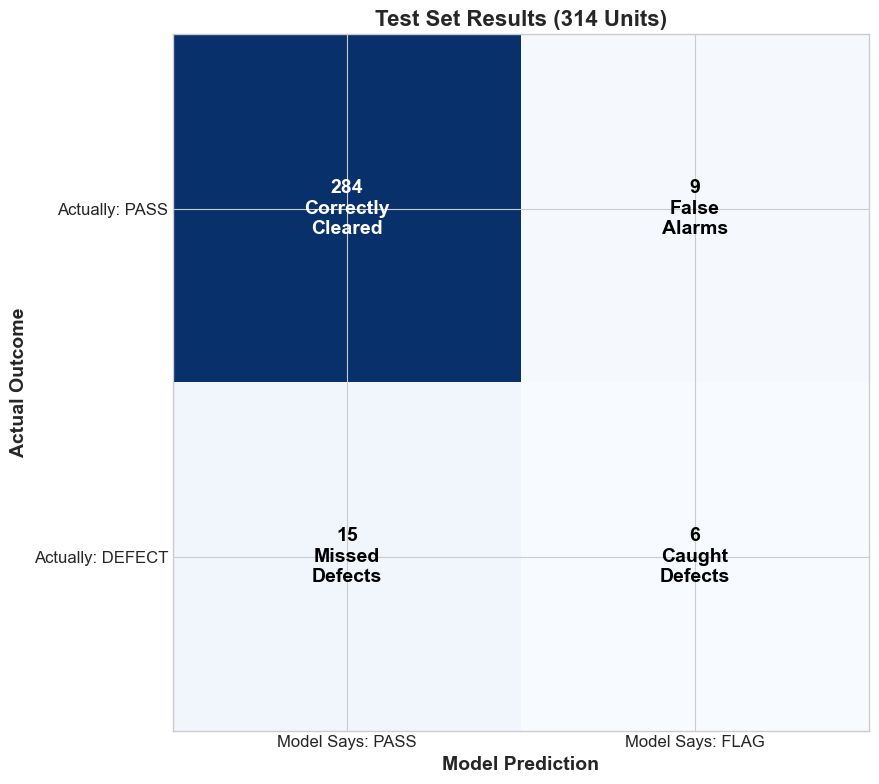


SUMMARY:
  - 284 units correctly cleared (no inspection needed)
  - 6 defects caught BEFORE downstream inspection
  - 9 false alarms (extra inspection, but no harm)
  - 15 defects missed (would need other detection methods)


In [4]:
# Confusion matrix visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Actual confusion matrix values from LightGBM + None
cm_data = np.array([[284, 9], [15, 6]])
labels = ['Pass', 'Defect']

# Create heatmap
im = ax.imshow(cm_data, cmap='Blues')

# Add text annotations
for i in range(2):
    for j in range(2):
        value = cm_data[i, j]
        if i == 0 and j == 0:
            text = f"{value}\nCorrectly\nCleared"
            color = 'white' if value > 150 else 'black'
        elif i == 0 and j == 1:
            text = f"{value}\nFalse\nAlarms"
            color = 'black'
        elif i == 1 and j == 0:
            text = f"{value}\nMissed\nDefects"
            color = 'black'
        else:
            text = f"{value}\nCaught\nDefects"
            color = 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=14, 
                fontweight='bold', color=color)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Model Says: PASS', 'Model Says: FLAG'], fontsize=12)
ax.set_yticklabels(['Actually: PASS', 'Actually: DEFECT'], fontsize=12)
ax.set_xlabel('Model Prediction', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual Outcome', fontsize=14, fontweight='bold')
ax.set_title('Test Set Results (314 Units)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSUMMARY:")
print(f"  - 284 units correctly cleared (no inspection needed)")
print(f"  - 6 defects caught BEFORE downstream inspection")
print(f"  - 9 false alarms (extra inspection, but no harm)")
print(f"  - 15 defects missed (would need other detection methods)")

---
## 3. The 5 Key Sensors to Monitor

The model relies most heavily on these sensors. **If any of these show unusual readings, defect risk increases.**

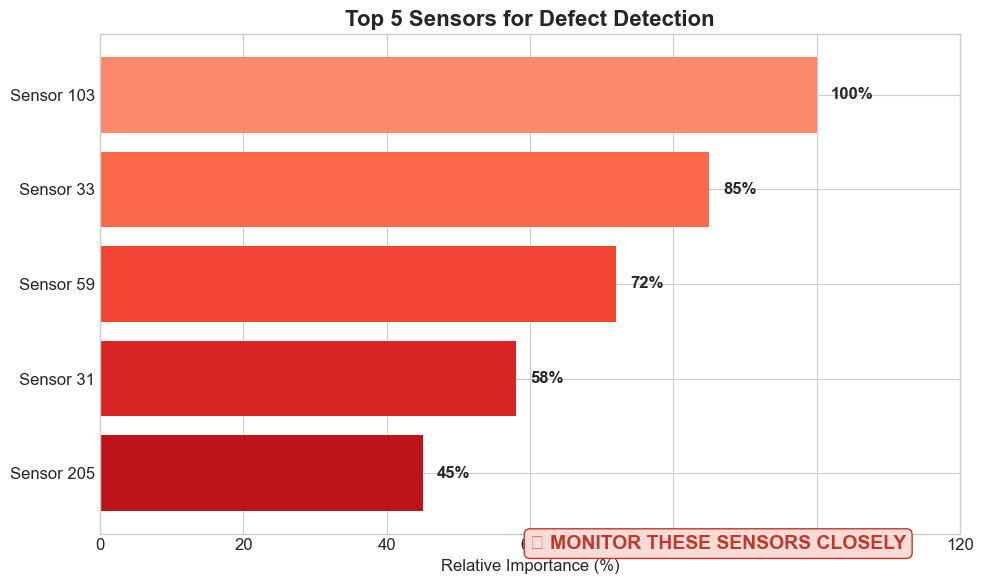

In [5]:
# Key sensors and their importance
key_sensors = {
    'Sensor 103': 100,  # Normalized importance (most important = 100)
    'Sensor 33': 85,
    'Sensor 59': 72,
    'Sensor 31': 58,
    'Sensor 205': 45
}

fig, ax = plt.subplots(figsize=(10, 6))

sensors = list(key_sensors.keys())
importance = list(key_sensors.values())
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(sensors)))

bars = ax.barh(sensors[::-1], importance[::-1], color=colors[::-1])

# Add value labels
for bar, val in zip(bars, importance[::-1]):
    ax.text(val + 2, bar.get_y() + bar.get_height()/2, 
            f'{val}%', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Relative Importance (%)', fontsize=12)
ax.set_title('Top 5 Sensors for Defect Detection', fontsize=16, fontweight='bold')
ax.set_xlim(0, 120)

# Add alert box
ax.text(60, -0.8, '\u26A0 MONITOR THESE SENSORS CLOSELY', 
        fontsize=14, fontweight='bold', color='#c0392b',
        bbox=dict(boxstyle='round', facecolor='#fadbd8', edgecolor='#c0392b'))

plt.tight_layout()
plt.show()

---
## 4. Sensor Value Distributions: Normal vs Defect

This shows how sensor readings differ between passing units and defective units:

In [6]:
# Prepare data for visualization
# Impute missing values for visualization
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Key sensor columns (using original column indices)
key_sensor_cols = [103, 33, 59, 31, 205]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sensor_num in enumerate(key_sensor_cols):
    ax = axes[idx]
    col_name = X.columns[sensor_num] if sensor_num < len(X.columns) else X.columns[0]
    
    # Get data for each class
    pass_values = X_imputed.loc[y == 0, col_name]
    fail_values = X_imputed.loc[y == 1, col_name]
    
    # Plot distributions
    ax.hist(pass_values, bins=30, alpha=0.6, color='#27ae60', 
            label=f'Pass (n={len(pass_values)})', density=True)
    ax.hist(fail_values, bins=30, alpha=0.6, color='#e74c3c', 
            label=f'Defect (n={len(fail_values)})', density=True)
    
    ax.set_title(f'Sensor {sensor_num}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Sensor Reading')
    ax.set_ylabel('Density')
    ax.legend()

# Remove empty subplot
axes[5].axis('off')
axes[5].text(0.5, 0.5, 'Look for shifts between\ngreen (pass) and red (defect)\ndistributions', 
             ha='center', va='center', fontsize=12, 
             transform=axes[5].transAxes,
             bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='gray'))

plt.suptitle('Sensor Value Distributions: Pass vs Defect', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("  - Where red (defect) shifts away from green (pass), that sensor helps detect defects")
print("  - More overlap = harder to distinguish defects from normal units")

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '2008-07-19 11:55:00'

---
## 5. How the Model Makes Decisions

**The Simple Rule:** If the model's probability score exceeds 9%, the unit is flagged for inspection.

In [ ]:
# Decision threshold visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Create example probability distribution
np.random.seed(42)
pass_probs = np.random.beta(1, 15, 293)  # Most passing units have low probabilities
defect_probs = np.concatenate([
    np.random.beta(2, 8, 15),   # Some defects detected (higher probs)
    np.random.beta(1, 20, 6)    # Some defects missed (low probs like passes)
])

# Plot distributions
ax.hist(pass_probs, bins=30, alpha=0.6, color='#27ae60', label='Passing Units')
ax.hist(defect_probs, bins=30, alpha=0.6, color='#e74c3c', label='Defective Units')

# Add threshold line
threshold = 0.09
ax.axvline(x=threshold, color='#2c3e50', linewidth=3, linestyle='--', label=f'Threshold = {threshold:.0%}')

# Add annotations
ax.annotate('FLAG FOR\nINSPECTION', xy=(0.3, ax.get_ylim()[1]*0.7), fontsize=14, 
            fontweight='bold', color='#c0392b', ha='center')
ax.annotate('CLEAR', xy=(0.02, ax.get_ylim()[1]*0.7), fontsize=14, 
            fontweight='bold', color='#27ae60', ha='center')

ax.fill_betweenx([0, ax.get_ylim()[1]], threshold, 1, alpha=0.1, color='red')

ax.set_xlabel('Model Probability Score', fontsize=12)
ax.set_ylabel('Number of Units', fontsize=12)
ax.set_title('How the Threshold Works', fontsize=16, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

print("\nDECISION RULE:")
print("  If Model Probability > 9%  -->  FLAG for inspection")
print("  If Model Probability <= 9% -->  CLEAR (proceed normally)")
print("\nWHY 9%?")
print("  - Lower threshold = catch more defects, but more false alarms")
print("  - Higher threshold = fewer false alarms, but miss more defects")
print("  - 9% balances detection rate with inspection workload")

---
## 6. Why Some Defects Are Missed

**Important:** Not all defects can be caught with current sensors. Here's why:

In [ ]:
# Defect difficulty visualization
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Easy Defects\n(Clear sensor anomalies)', 
              'Medium Defects\n(Subtle signals)', 
              'Hard Defects\n(Normal-looking sensors)']
percentages = [25, 35, 40]
colors = ['#27ae60', '#f39c12', '#e74c3c']
detection = ['Most detected', 'Sometimes detected', 'Rarely detected']

bars = ax.bar(categories, percentages, color=colors, edgecolor='black', linewidth=2)

# Add percentage labels
for bar, pct, det in zip(bars, percentages, detection):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{pct}%', ha='center', fontsize=16, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
            det, ha='center', fontsize=11, color='white', fontweight='bold')

ax.set_ylabel('Percentage of Defects', fontsize=12)
ax.set_title('Not All Defects Are Equally Detectable', fontsize=16, fontweight='bold')
ax.set_ylim(0, 55)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("  ~40% of defects have NORMAL sensor readings")
print("  --> No algorithm can detect them with current data")
print("  --> May need additional sensors or process changes")
print("\nQUESTIONS FOR PROCESS ENGINEERS:")
print("  1. What do Sensors 103, 33, 59 actually measure?")
print("  2. Are there process parameters we're NOT monitoring?")
print("  3. Do 'hard' defects have a different root cause?")

---
## 7. Quick Reference Card

Print this and post near the workstation:

In [ ]:
# Reference card
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'DEFECT DETECTION MODEL - QUICK REFERENCE', 
        ha='center', fontsize=18, fontweight='bold', 
        transform=ax.transAxes)

# Box 1: What it does
box1 = plt.Rectangle((0.02, 0.7), 0.45, 0.2, fill=True, 
                       facecolor='#d5f5e3', edgecolor='#27ae60', linewidth=2)
ax.add_patch(box1)
ax.text(0.245, 0.85, 'WHAT THE MODEL DOES', ha='center', fontsize=12, fontweight='bold')
ax.text(0.245, 0.78, 'Analyzes 287 sensor readings', ha='center', fontsize=10)
ax.text(0.245, 0.73, 'Flags units with >9% defect probability', ha='center', fontsize=10)

# Box 2: Performance
box2 = plt.Rectangle((0.53, 0.7), 0.45, 0.2, fill=True, 
                       facecolor='#d6eaf8', edgecolor='#3498db', linewidth=2)
ax.add_patch(box2)
ax.text(0.755, 0.85, 'PERFORMANCE', ha='center', fontsize=12, fontweight='bold')
ax.text(0.755, 0.78, 'Catches: 30% of defects', ha='center', fontsize=10)
ax.text(0.755, 0.73, 'Precision: 40% (4 of 10 flags are real)', ha='center', fontsize=10)

# Box 3: Key sensors
box3 = plt.Rectangle((0.02, 0.4), 0.45, 0.25, fill=True, 
                       facecolor='#fdebd0', edgecolor='#f39c12', linewidth=2)
ax.add_patch(box3)
ax.text(0.245, 0.60, 'KEY SENSORS TO WATCH', ha='center', fontsize=12, fontweight='bold')
ax.text(0.245, 0.53, '#1: Sensor 103', ha='center', fontsize=10)
ax.text(0.245, 0.48, '#2: Sensor 33', ha='center', fontsize=10)
ax.text(0.245, 0.43, '#3: Sensor 59, 31, 205', ha='center', fontsize=10)

# Box 4: Action guide
box4 = plt.Rectangle((0.53, 0.4), 0.45, 0.25, fill=True, 
                       facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
ax.add_patch(box4)
ax.text(0.755, 0.60, 'WHEN MODEL FLAGS A UNIT', ha='center', fontsize=12, fontweight='bold')
ax.text(0.755, 0.53, '1. Check Sensors 103, 33, 59', ha='center', fontsize=10)
ax.text(0.755, 0.48, '2. Prioritize for inspection', ha='center', fontsize=10)
ax.text(0.755, 0.43, '3. Log outcome for model feedback', ha='center', fontsize=10)

# Box 5: Limitations
box5 = plt.Rectangle((0.15, 0.1), 0.7, 0.22, fill=True, 
                       facecolor='#f4f6f7', edgecolor='#7f8c8d', linewidth=2)
ax.add_patch(box5)
ax.text(0.5, 0.27, 'LIMITATIONS TO REMEMBER', ha='center', fontsize=12, fontweight='bold')
ax.text(0.5, 0.21, '~40% of defects cannot be detected with current sensors', ha='center', fontsize=10)
ax.text(0.5, 0.16, 'This is a SCREENING tool, not a replacement for inspection', ha='center', fontsize=10)
ax.text(0.5, 0.11, 'Model should be retrained quarterly or if defect patterns change', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('reference_card.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nReference card saved as 'reference_card.png'")

---
## 8. Interactive: Check a Specific Unit

Enter a unit index to see why it was flagged or cleared:

In [ ]:
# Train model for prediction explanation
# Simplified preprocessing for dashboard
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imp)

X_test_imp = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imp)

# Train model
model = LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    class_weight='balanced',
    num_leaves=31,
    min_data_in_leaf=20,
    learning_rate=0.1
)
model.fit(X_train_scaled, y_train)

# Get predictions
test_probs = model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_probs > 0.09).astype(int)

print("Model trained and ready for unit lookup!")
print(f"\nTest set indices: 0 to {len(X_test)-1}")

In [ ]:
def explain_unit(unit_idx):
    """Explain why a specific unit was flagged or cleared."""
    if unit_idx < 0 or unit_idx >= len(X_test):
        print(f"Invalid index. Please use 0-{len(X_test)-1}")
        return
    
    prob = test_probs[unit_idx]
    pred = test_preds[unit_idx]
    actual = y_test.iloc[unit_idx]
    
    print("="*60)
    print(f"UNIT {unit_idx} ANALYSIS")
    print("="*60)
    
    # Prediction status
    status = "FLAGGED" if pred == 1 else "CLEARED"
    actual_str = "DEFECTIVE" if actual == 1 else "PASS"
    
    print(f"\nModel Probability: {prob:.1%}")
    print(f"Threshold: 9%")
    print(f"Model Decision: {status}")
    print(f"Actual Outcome: {actual_str}")
    
    # Outcome classification
    if pred == 1 and actual == 1:
        print("\n--> TRUE POSITIVE: Defect correctly caught!")
    elif pred == 1 and actual == 0:
        print("\n--> FALSE ALARM: Flagged but was actually fine")
    elif pred == 0 and actual == 1:
        print("\n--> MISSED DEFECT: Should have been flagged")
    else:
        print("\n--> TRUE NEGATIVE: Correctly cleared")
    
    # Key sensor readings
    print("\nKey Sensor Readings (standardized):")
    key_indices = [103, 33, 59, 31, 205]
    for idx in key_indices:
        if idx < X_test_scaled.shape[1]:
            val = X_test_scaled[unit_idx, idx]
            status = "NORMAL" if abs(val) < 2 else "ELEVATED" if val > 0 else "LOW"
            print(f"  Sensor {idx}: {val:+.2f} ({status})")
    
    print("="*60)

# Example: Check unit 0
explain_unit(0)

In [ ]:
# Try different units - change the number below!
explain_unit(5)  # <-- Change this number to check different units

---
## 9. Summary Statistics for Shift Reports

Copy these stats into your shift reports:

In [ ]:
# Summary stats for reporting
n_flagged = test_preds.sum()
n_total = len(test_preds)
n_defects = y_test.sum()
n_caught = ((test_preds == 1) & (y_test == 1)).sum()
n_false_alarms = ((test_preds == 1) & (y_test == 0)).sum()
n_missed = ((test_preds == 0) & (y_test == 1)).sum()

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nTotal units analyzed: {n_total}")
print(f"Units flagged by model: {n_flagged} ({n_flagged/n_total*100:.1f}%)")
print(f"")
print(f"Actual defects in batch: {n_defects}")
print(f"Defects caught by model: {n_caught} ({n_caught/n_defects*100:.1f}%)")
print(f"Defects missed: {n_missed} ({n_missed/n_defects*100:.1f}%)")
print(f"")
print(f"False alarms: {n_false_alarms}")
print(f"Flag accuracy: {n_caught/(n_caught+n_false_alarms)*100:.1f}% of flags were real defects")
print("="*60)

---
## Questions? Issues?

**Contact:** Data Science Team

**Report issues with:**
- Units that the model consistently misses
- New defect types not being caught
- Sensor readings that seem off

**Model retraining:** Scheduled quarterly, or on-demand if defect patterns change significantly.

---
*Dashboard created for UCI SECOM semiconductor defect detection project*